# Beatbot

I had the idea a few years ago to build an app that would process audio of beatboxing (vocal percussion), do some magic, then spit out a new audio track composed of drum noises.

A couple months ago that I got the time to get serious about working on this idea. This ended up being a super interesting data science / signal processing problem closely related to the well documented area of speech-processing algorithims. This was my first project that involved a lot more research than heads-down coding time.

So far I've built an algorithm that works decently on quality beatboxing tracks.

I call this tool "beatbot". Here's how it works.

## Table of contents

* Beat location
* Beat classification
* Beat replacement

## Part I: Beat location

The first step in beatbot is to locate all the beats in the given audio wave. Here's an example beatbox track. 

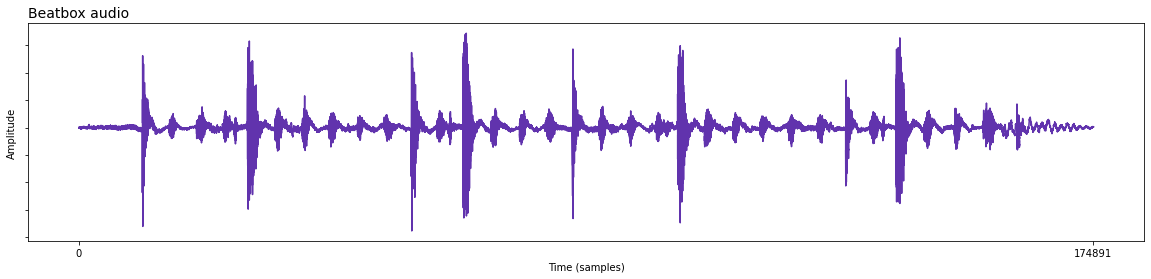

In [1]:
import IPython
import librosa
from src import plot_utils

%matplotlib inline

BEATBOX_AUDIO_FILE = 'assets/beatbox_1.wav'

# Load audio
audio, sample_rate = librosa.load(BEATBOX_AUDIO_FILE, mono=True)

# Plot
plot_utils.plot(y=audio, title='Beatbox audio', xlabel='Time (samples)', ylabel='Amplitude')

# Display audio player
IPython.display.Audio(BEATBOX_AUDIO_FILE)

Visually, we can already begin to see where the beats are located in the waveform, but there are too many points and too much noise to easily work out where the beats begin and end.

To get a get a cleaner representation showing where our beats lie, we'll start by taking a look at the the frequencies in this audio track over time. We'll do this by applying the "Fourier transform" to small, overlapping windows of our audio wave.

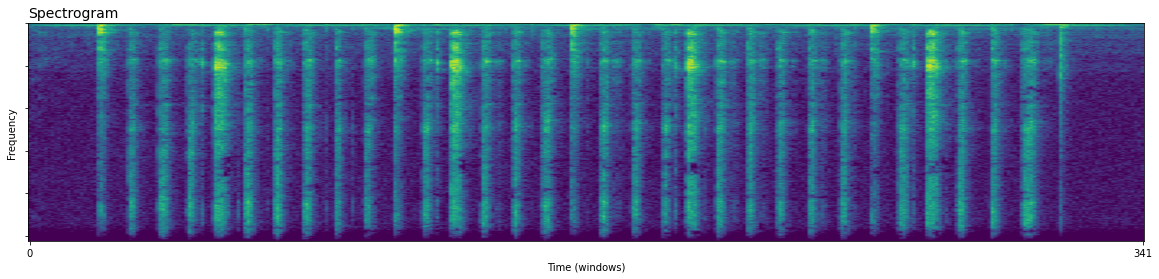

In [2]:
import numpy as np

# Windows of audio 23ms long with 12ms of overlap
WINDOW_SIZE = 1024
WINDOW_OVERLAP = 512

# Take the 'short time' Fourier transform of the audio signal
spectrogram = librosa.stft(y=audio, win_length=WINDOW_SIZE, hop_length=WINDOW_OVERLAP)

# Convert imaginary numbers to real numbers
spectrogram = np.abs(spectrogram)

# Convert from amplitude to decibels
spectrogram = librosa.amplitude_to_db(spectrogram)

# Plot
plot_utils.heatmap(data=spectrogram, title='Spectrogram', xlabel='Time (windows)', ylabel='Frequency')

In this visualization of our audio frequencies over time (known as a spectrogram), we can clearly see where each beat is located. Yellower colors indicate loudness while bluer colors indicate quietness. Positions near the top represent high frequencies, while lower positions show low frequencies.

This visualization represents what us humans are hearing far better than the raw waveform. Humans hear frequencies with logarithmic intensity, meaning that we're that we're able to distinguish subtle differences in high frequencies but only large differences in low frequencies. We're able to well represent that aspect of human hearing in our spectrogram when we convert our raw amplitude values to decibel values which lie on a logarithmic scale like human hearing.

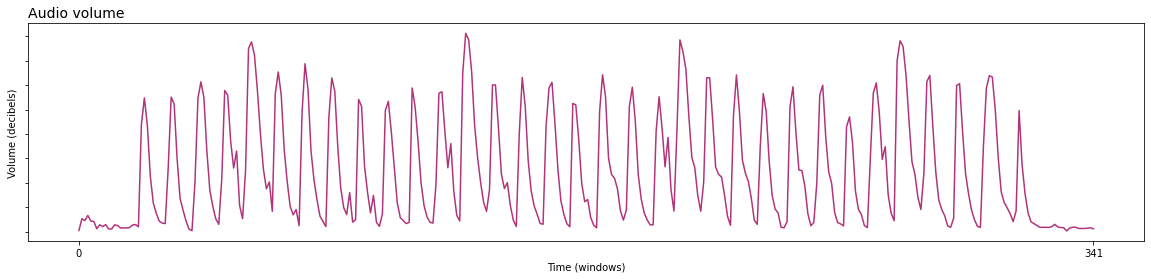

In [3]:
# Sum the spectrogram by column
volume = np.sum(spectrogram, axis=0)

# Plot
plot_utils.plot(volume, title='Audio volume', xlabel='Time (windows)', ylabel='Volume (decibels)')

Finally, by summing our spectrogram by column, we get a great representation of how loud the audio is over time. We can see 33 clear peaks each representing a beat in our audio. All we have to do now is write some code to automatically find where each of these peaks begins and ends.

A core tool for this process will be SciPy's peak finding utility which can take a signal and a prominence value then return the location of all the peaks with at least that prominence. The only problem is that for any given audio track, we won't know what prominence value to use. To solve this, we'll just try a bunch and see what the most popular result is!

Most frqeuent number of peaks: 33


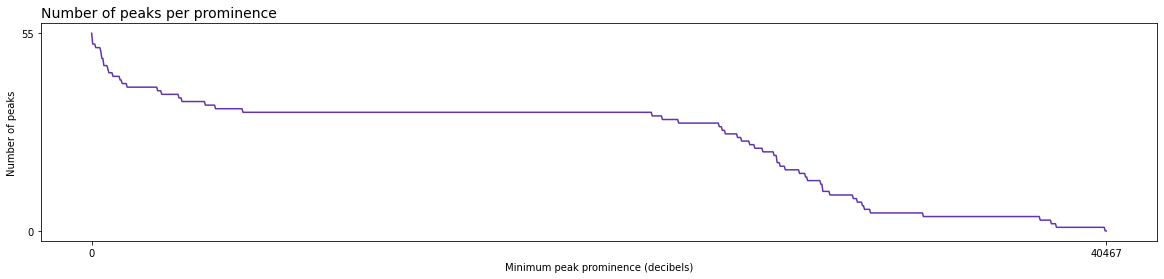

In [4]:
import scipy
import matplotlib.pyplot as plt

MIN_PROMINENCE = 0
MAX_PROMINENCE = np.max(volume) - np.min(volume)
NUM_PROMINENCES = 1000

# Create an array of prominence values
prominences = np.linspace(MIN_PROMINENCE, MAX_PROMINENCE, NUM_PROMINENCES)

# For each prominence value, calculate the # of peaks of at least that prominence
num_peaks = []
for prominence in prominences:
    peak_data = scipy.signal.find_peaks(volume, prominence=prominence)
    num_peaks.append(len(peak_data[0]))
    
# Calculate the most frequent peak quantity
most_frequent_num_peaks = np.argmax(np.bincount(num_peaks)) 
print('Most frqeuent number of peaks:', most_frequent_num_peaks)

#Plot
plot_utils.plot(
    x=prominences,
    y=num_peaks,
    title='Number of peaks per prominence',
    xlabel='Minimum peak prominence (decibels)',
    ylabel='Number of peaks',
    show_yticks=True
)

That long horizontal flat line that can be seen in the graph lies exactly at 33 peaks, the expected number of beats in the audio! This method of trying many different prominence values shows us that these 33 peaks are the most significant of any of the peaks in the volume signal.

From here, we can work backwards a little bit and extract the full peak data from these 33 peaks.

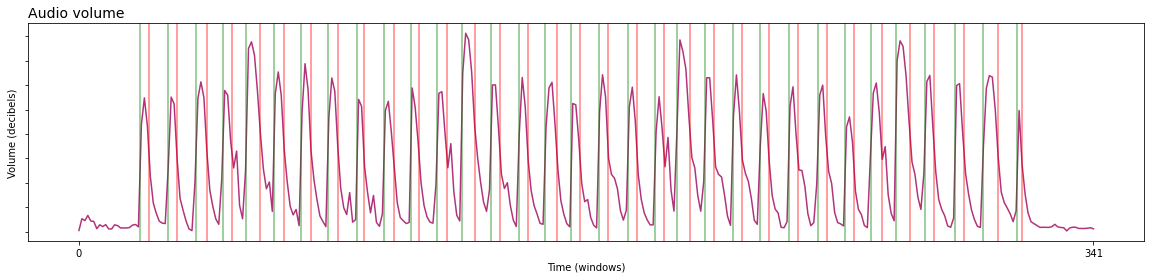

In [5]:
# Define the starts and ends of peak to be the intersection of 50% of the peak's prominence
PROMINENCE_MEASURING_POINT = 0.5

# Get a prominence value for which there are 33 peaks
prominence_index = np.where(np.array(num_peaks) == most_frequent_num_peaks)[0][0]
prominence = prominences[prominence_index]

# Calculate starts and ends of each peak
peak_data = scipy.signal.find_peaks(volume, prominence=prominence, width=0, rel_height=PROMINENCE_MEASURING_POINT)
peak_starts = peak_data[1]['left_ips']
peak_ends = peak_data[1]['right_ips']

# Plot
plot_utils.plot(volume, title='Audio volume', xlabel='Time (windows)', ylabel='Volume (decibels)', show=False)
for peak_start, peak_end in zip(peak_starts, peak_ends):
    plt.axvline(peak_start, c='green', alpha=0.5)
    plt.axvline(peak_end, c='red', alpha=0.5)
plt.show()

And just like that, we have the locations of each beat. The last thing to do is scale these location markers from windows back to samples to extract the beats from the original audio.

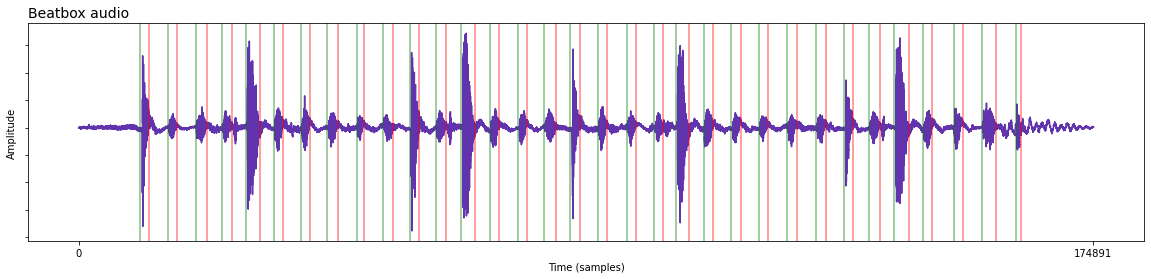

In [6]:
# Scale up peak starts and ends
beat_starts = librosa.frames_to_samples(peak_starts, hop_length=WINDOW_OVERLAP)
beat_ends = librosa.frames_to_samples(peak_ends, hop_length=WINDOW_OVERLAP)

# Plot
plot_utils.plot(y=audio, title='Beatbox audio', xlabel='Time (samples)', ylabel='Amplitude', show=False)
for beat_start, beat_end in zip(beat_starts, beat_ends):
    plt.axvline(beat_start, c='green', alpha=0.5)
    plt.axvline(beat_end, c='red', alpha=0.5)
plt.show()

## Part II: Beat classification

Now that we the locations of all of the beats in the track, we need to determine which sounds represent the same vocal percussion sound. If the beatboxer records audio that sounds like "pft ts kuh ts pft ts kuh ts", the job of the beat classifier is to return the pattern "0 1 2 1 0 1 2 1".

To start off, lets look at our beats.

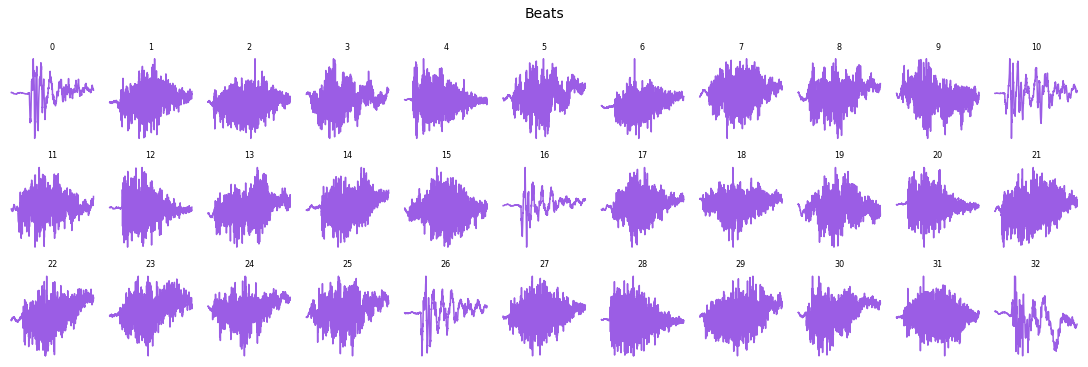

In [7]:
from src import multi_plot_utils

# Extract beats' audio
beats = []
for beat_start, beat_end in zip(beat_starts, beat_ends):
    beat = audio[beat_start:beat_end]
    beats.append(beat)

# Plot
multi_plot_utils.multi_plot(beats, title='Beats')

Listening to the audio again, our expected beat pattern should be "0 1 1 1 2 1 1 1 1 1 0 1 2 1 1 1 0 1 1 1 2 1 1 1 1 1 0 1 2 1 1 1 3". 

The final beat is some kind of unintentional knocking noise that occured when the recorder was being turned off. 

Lets visualize this.

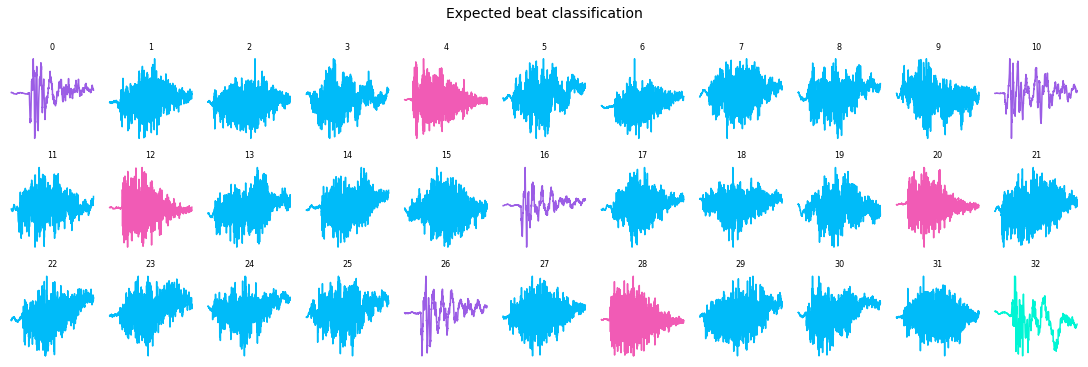

In [8]:
EXPECTED_PATTERN = [0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 3]

# Plot
multi_plot_utils.multi_plot(beats, title='Expected beat classification', pattern=EXPECTED_PATTERN)

# Also here's the audio if you want to listen again
IPython.display.Audio(BEATBOX_AUDIO_FILE)

Our first task is to featurize our beats. A proven audio featurization method popular in speech processing algorithms is extracting "Mel-frequency cepstral coefficients" (MFCCs) from the audio.

MFCCs are basically created in three steps. First, audio is transformed to its frequency comopnents via the Fourier transform. Next, Mel-coefficients are extracted from each set of frequencies in time (the Mel scale is essentially the human hearing scale). And lastly, These values are compressed usually using the inverse discrete cosine transform. Some more specifics to this that I found helpful can be found here: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

Lets extract some MFCCs from our beats now.

/home/alexcrist/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=822
  warnings.warn(


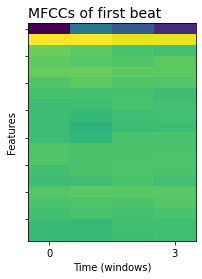

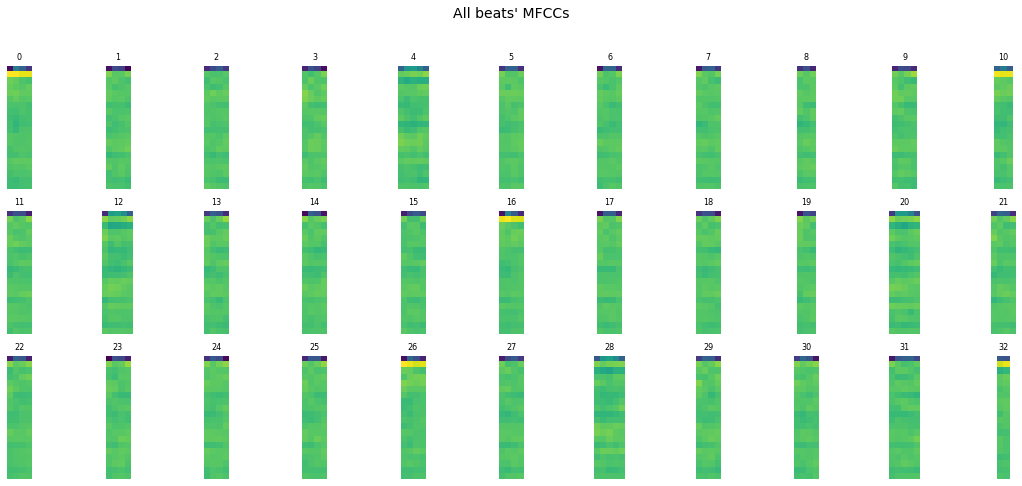

In [9]:
# From each beat, create a set of MFCCs
mfccs = []
for beat in beats:
    mfcc = librosa.feature.mfcc(
        beat, 
        win_length=WINDOW_SIZE, 
        hop_length=WINDOW_OVERLAP,
        n_fft=1024
    )
    mfccs.append(mfcc)

# Plot
plot_utils.heatmap(mfccs[0], figsize=(3, 4), title='MFCCs of first beat', xlabel='Time (windows)', ylabel='Features')
multi_plot_utils.multi_heatmap(mfccs, title='All beats\' MFCCs')

These featurizations may all look the same, but if you look closely, we can actually see similarities in the beats that should be classified as the same sound.

Next we'll look to compare each beat's MFCCs to every other beat's MFCCs. The challenge here is that not all beats'MFCCs are the same shape. Beat #31 has a width of six time windows while beat #32 has a width of three time windows. To effectively compare these differently sized feature sets, we'll use a technique called Dynamic Time Warping (DTW).

The below image demonstrates how DTW more flexibily compares two feature sets. 

<img src="assets/dtw.jpeg" style="height: 600px" />

Image taken from: https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

Now using DTW, lets measure the distance between each pair of beats. We'll store this result in a distance matrix.

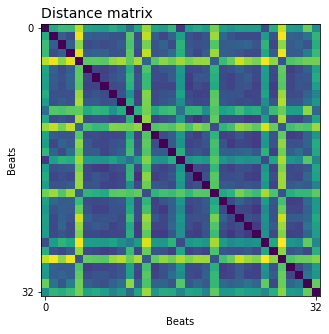

In [10]:
# Create a distance matrix measuring the distance between each pair of beats' MFCCs
distance_matrix = np.full((len(mfccs), len(mfccs)), -1)
for i in range(len(mfccs)):
    for j in range(len(mfccs)):
        
        # If we are comparing a MFCC set to itself, distance is 0
        if i == j:
            distance_matrix[i][j] = 0
            
        # If we haven't calculated the distance already, calculate it
        elif distance_matrix[i][j] == -1:
            distance = librosa.sequence.dtw(mfccs[i], mfccs[j])[0][-1][-1]
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance

# Plot
plot_utils.heatmap(distance_matrix, figsize=(5, 5), title='Distance matrix', xlabel='Beats', ylabel='Beats', show_yticks=True)

In this visualization, a dark pixel at coordinate (x, y) indicates that beat x and beat y are similar. A yellow pixel indicates dissimilarity.

Now that we know the distance between each beat, we can use a clustering algorithm to group together similar beats. I chose to use hierarchical clustering for this.

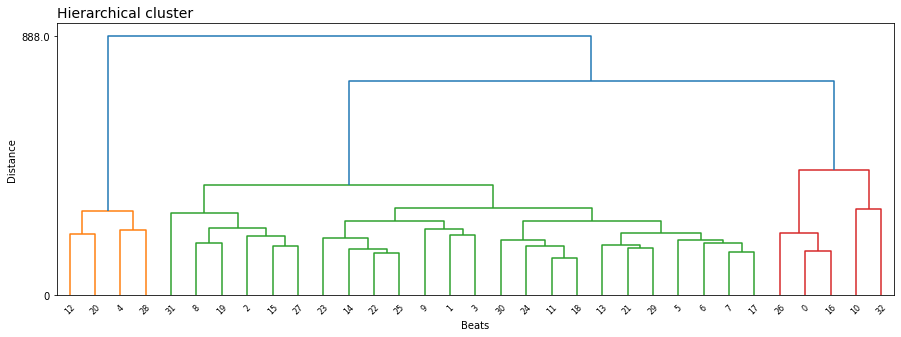

In [11]:
import scipy.cluster

# Create hierarchical cluster of beats
condensed_matrix = scipy.spatial.distance.squareform(distance_matrix)
cluster_data = scipy.cluster.hierarchy.linkage(condensed_matrix, 'complete')
max_distance = cluster_data[:,2][-1]

# Plot
plot_utils.plot([0], figsize=(15, 5), title='Hierarchical cluster', xlabel='Beats', ylabel='Distance', show=False)
ax = plt.gca()
ax.set_yticks([0, max_distance])
ax.set_yticklabels([0, max_distance])
scipy.cluster.hierarchy.dendrogram(cluster_data, ax=ax)
plt.show()

The above figure is a dendrogram. It represents many clustering possibilities. The idea is that you pick a distance that defineds how close points need to be to one another to be clustered together. You then cut the dendrogram horizontally at that distance value on the y-axis. Each vertical line that intersects that cut represents a cluster with the connected points below belonging to that cluster.

One method of determining a good number of clusters is by looking at how the number of clusters changes as we change the distance value to cut at.

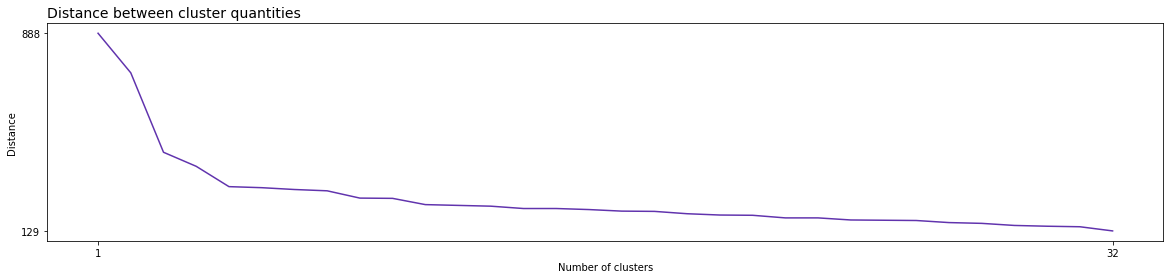

In [12]:
# Extract cluster distances from the cluster data
cluster_distances = cluster_data[::-1,2]
num_clusters = range(1, len(cluster_distances) + 1)

# Plot
plot_utils.plot(
    x=num_clusters, 
    y=cluster_distances, 
    title='Distance between cluster quantities', 
    xlabel='Number of clusters',
    ylabel='Distance',
    show_yticks=True
)

Given the above chart, a popular method to determine a good cluster quantity is to look for "knee points" in the graph as defined by maxima in the second degree differential.

More info on that here: https://stackoverflow.com/a/21723473/4762063

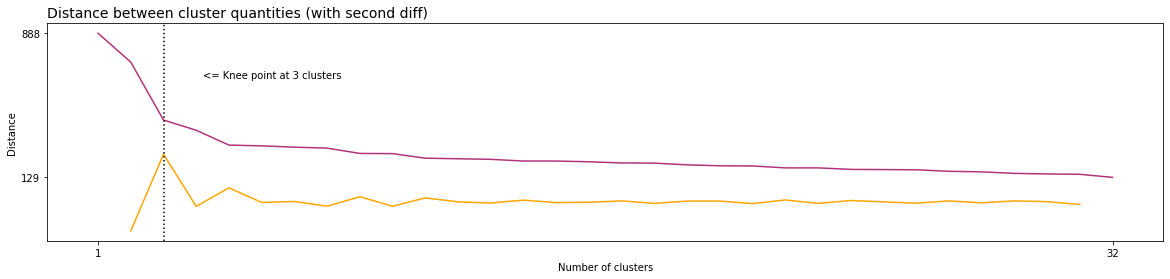

In [13]:
# Calculate the second differential line
second_diff = np.diff(cluster_distances, 2)
num_clusters_second_diff = num_clusters[1:-1]
cluster_quantity = np.argmax(second_diff) + num_clusters_second_diff[0]

# Plot
plot_utils.plot(
    x=num_clusters, 
    y=cluster_distances, 
    title='Distance between cluster quantities (with second diff)', 
    xlabel='Number of clusters',
    ylabel='Distance',
    show_yticks=True,
    show=False
)
plt.plot(num_clusters[1:-1], second_diff, c='orange')
plt.axvline(cluster_quantity, c='black', ls=':')
plt.text(x=4.2, y=650, s='<= Knee point at ' + str(cluster_quantity) + ' clusters')
plt.show()

Now that we know how many clusters there are, we can look at which beats are clustered together.

Pattern: [3 2 2 2 1 2 2 2 2 2 3 2 1 2 2 2 3 2 2 2 1 2 2 2 2 2 3 2 1 2 2 2 3]


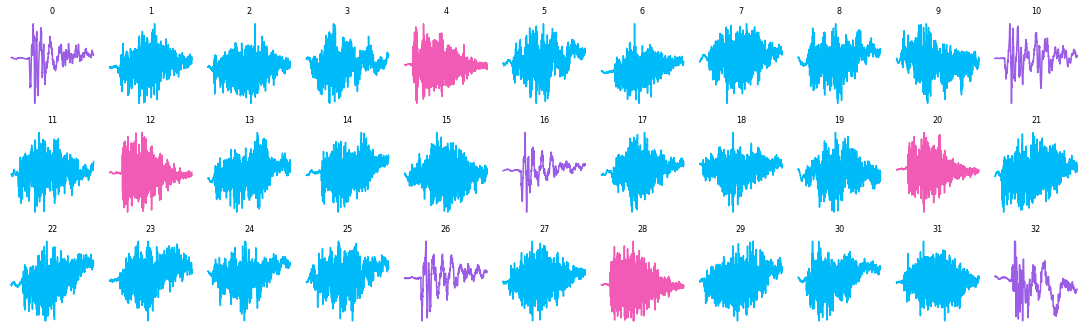

In [14]:
# For our chosen cluster quantity, retrieve the cluster pattern
pattern = scipy.cluster.hierarchy.fcluster(
    cluster_data, 
    cluster_quantity, 
    'maxclust'
)
print('Pattern:', pattern)

# Plot
multi_plot_utils.multi_plot(beats, title='', pattern=pattern)

Pretty good! The only classification we didn't expect was for beat #32 (the unintentional knock noise) to join with the purple "pft" beats.

## Beat replacement

At this point, we've done most of the heavy lifting. All that remains is to replace the beatbox sounds with drum kit sounds. I've curated 50 different drum kit sounds to choose from.

We'll start out by choosing a drum kit sound for each of our three beatbox sound classifications.

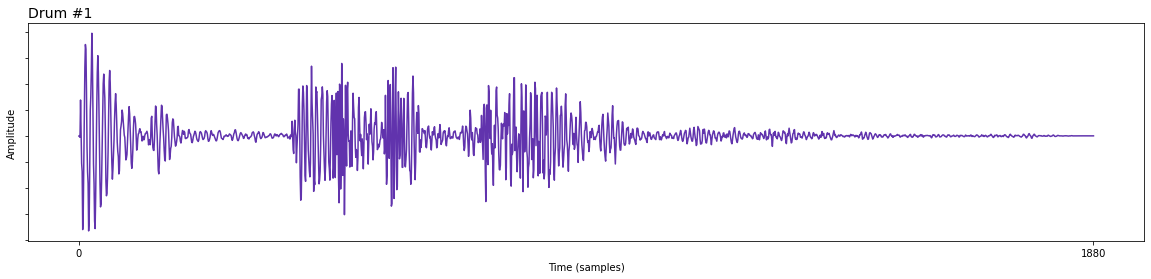

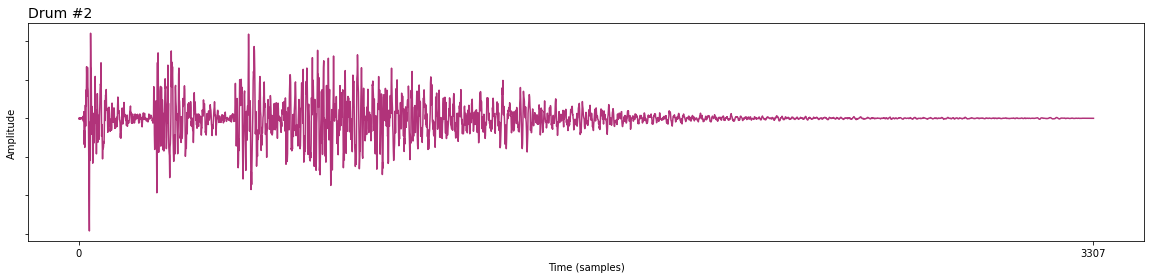

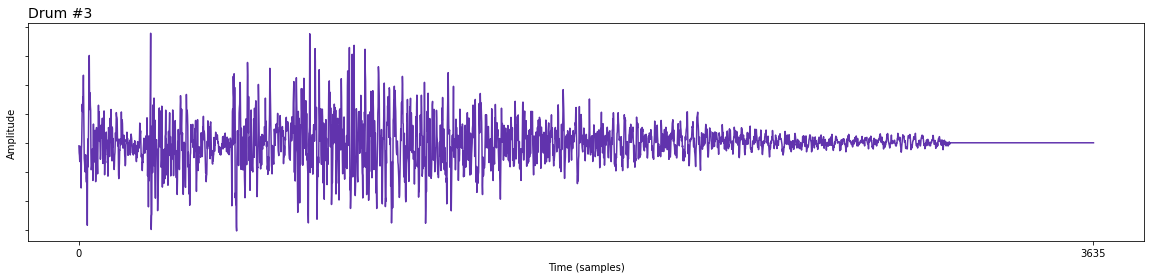

In [15]:
import os

DRUM_FOLDER = 'assets/drums/'

# Get all drum kit file paths
drum_files = os.listdir(DRUM_FOLDER)

# Extract MFCCs from each drum kit sound
drum_sounds = []
drum_mfccs = []
for file in drum_files:
    audio, sample_rate = librosa.load(DRUM_FOLDER + file)
    mfcc = librosa.feature.mfcc(
        audio,
        win_length=WINDOW_SIZE, 
        hop_length=WINDOW_OVERLAP,
        n_fft=1024
    )
    drum_sounds.append(audio)
    drum_mfccs.append(mfcc)

# Create a map from beatbox sound classifications to drum kit sounds
beatbox_to_drum_map = {}

# Keep track of which drum sounds we've used to avoid repeats
drums_used = []

for beat_mfcc, classification in zip(mfccs, pattern):
    if classification not in beatbox_to_drum_map:
        
        # Find the drum kit sound most similar to the beatbox sound
        best_distance = float('inf')
        best_drum_sound = None
        best_drum_file = None
        for drum_sound, drum_mfcc, drum_file in zip(drum_sounds, drum_mfccs, drum_files):
            
            # No repeats allowed
            if drum_file in drums_used:
                continue
            
            # Calculate distance using previous DTW approach
            distance = librosa.sequence.dtw(beat_mfcc, drum_mfcc)[0][-1][-1]
            if distance < best_distance:
                best_distance = distance
                best_drum_sound = drum_sound
                best_drum_file = drum_file
            
        # Update drum map
        beatbox_to_drum_map[classification] = best_drum_sound
        drums_used.append(best_drum_file)
        
# Plot
for index, drum_sound in enumerate(beatbox_to_drum_map.values()):
    plot_utils.plot(drum_sound, title='Drum #' + str(index + 1), xlabel='Time (samples)', ylabel='Amplitude')
    IPython.display.display(IPython.display.Audio(data=drum_sound, rate=sample_rate))

Great! Now that we have our sounds, all thats left to do is assemble them into a track.

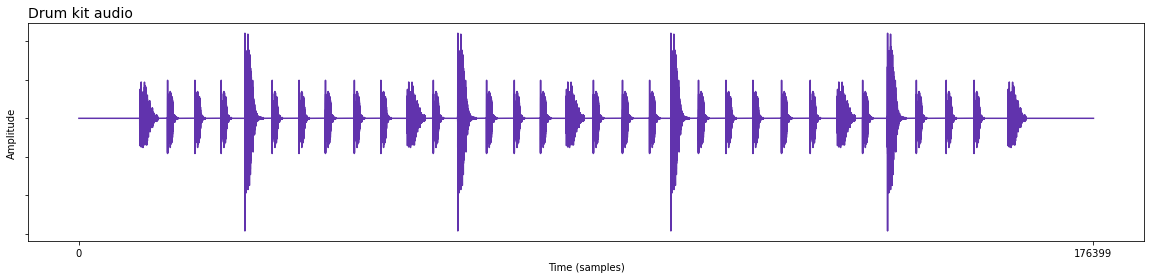

Final product:


And the original again:


In [19]:
# Create 10 seconds of empty audio
track = np.zeros(sample_rate * 8)

# Add drum sounds to the track
for beat_start, classification in zip(beat_starts, pattern):
    drum_sound = beatbox_to_drum_map[(classification + 0) % 3 + 1]
    drum_sound = np.concatenate([
        np.zeros(beat_start),
        drum_sound,
        np.zeros(len(track) - len(drum_sound) - beat_start)
    ])
    track += drum_sound
    
# Plot
plot_utils.plot(track, title='Drum kit audio', xlabel='Time (samples)', ylabel='Amplitude')
print('Final product:')
IPython.display.display(IPython.display.Audio(data=track, rate=sample_rate))
print('And the original again:')
IPython.display.display(IPython.display.Audio(BEATBOX_AUDIO_FILE))

And we're done!